In [1]:
import sys

In [2]:
print(sys.version)

3.5.4 (default, Aug  8 2017, 11:09:21) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-11)]


In [3]:
import os
from PIL import Image
import cv2
from keras import backend as K
K.set_image_data_format( 'channels_last' ) 


from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split

Using TensorFlow backend.
/usr/lib64/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
DatasetPath=[]
imageLabels=[]
k=-1
for i in os.listdir("faces94/male"):
    k=k+1
    for j in os.listdir("faces94/male/"+i):
        DatasetPath.append(os.path.join("faces94/male/",i,j))
        imageLabels.append(k)
print (k)

112


In [5]:
imageData=[]
for i in DatasetPath:
    imgRead=cv2.imread(i)
    imgRead=cv2.resize(imgRead,(224,224))
    imageData.append(imgRead)

In [7]:
print (len(imageData))
print (len(imageLabels))

2260
2260


In [8]:
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
def convblock(cdim, nb, bits=3):
    L = []
    
    for k in range(1,bits+1):
        convname = 'conv'+str(nb)+'_'+str(k)
        #L.append( Convolution2D(cdim, 3, 3, border_mode='same', activation='relu', name=convname) ) # Keras 1
        L.append( Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname) ) # Keras 2
    
    L.append( MaxPooling2D((2, 2), strides=(2, 2)) )
    
    return L

In [10]:
def vgg_face_blank():
    
    withDO = True # no effect during evaluation but usefull for fine-tuning
    
    if True:
        mdl = Sequential()
        
        # First layer is a dummy-permutation = Identity to specify input shape
        mdl.add( Permute((1,2,3), input_shape=(224,224,3)) ) # WARNING : 0 is the sample dim

        for l in convblock(64, 1, bits=2):
            mdl.add(l)

        for l in convblock(128, 2, bits=2):
            mdl.add(l)
        
        for l in convblock(256, 3, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 4, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 5, bits=3):
            mdl.add(l)
        
        #mdl.add( Convolution2D(4096, 7, 7, activation='relu', name='fc6') ) # Keras 1
        mdl.add( Convolution2D(4096, kernel_size=(7, 7), activation='relu', name='fc6') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
        #mdl.add( Convolution2D(4096, 1, 1, activation='relu', name='fc7') ) # Keras 1
        mdl.add( Convolution2D(4096, kernel_size=(1, 1), activation='relu', name='fc7') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
        #mdl.add( Convolution2D(2622, 1, 1, name='fc8') ) # Keras 1
        mdl.add( Convolution2D(2622, kernel_size=(1, 1), activation='relu', name='fc8') ) # Keras 2
        mdl.add( Flatten() )
        mdl.add( Activation('softmax') )
        
        return mdl
    
    else:
        # See following link for a version based on Keras functional API :
        # gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9
        raise ValueError('not implemented')

In [11]:
facemodel = vgg_face_blank()
facemodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

In [12]:
from scipy.io import loadmat

In [14]:
data = loadmat('vgg-face.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
description = data['meta'][0,0].classes[0,0].description


In [15]:
l.shape, description.shape

((1, 37), (2622, 1))

In [16]:
l[0,10][0,0].type[0], l[0,10][0,0].name[0]

('conv', 'conv3_1')

In [17]:
l[0,10][0,0].weights[0,0].shape, l[0,10][0,0].weights[0,1].shape

((3, 3, 128, 256), (256, 1))

In [18]:
def weight_compare(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]

    # WARNING : important setting as 2 of the 4 axis have same size dimension
    #prmt = (3,2,0,1) # INFO : for 'th' setting of 'dim_ordering'
    prmt = (0,1,2,3) # INFO : for 'channels_last' setting of 'image_data_format'

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        mattype = l[0,i][0,0].type[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print(matname, mattype)
            print(l[0,i][0,0].weights[0,0].transpose(prmt).shape, l[0,i][0,0].weights[0,1].shape)
            print(kmodel.layers[kindex].get_weights()[0].shape, kmodel.layers[kindex].get_weights()[1].shape)
            print('------------------------------------------')
        else:
            print('MISSING : ', matname, mattype)
            print('------------------------------------------')

In [19]:
def copy_mat_to_keras(kmodel):

    kerasnames = [lr.name for lr in kmodel.layers]

    # WARNING : important setting as 2 of the 4 axis have same size dimension
    #prmt = (3,2,0,1) # INFO : for 'th' setting of 'dim_ordering'
    prmt = (0,1,2,3) # INFO : for 'channels_last' setting of 'image_data_format'

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            #print matname
            l_weights = l[0,i][0,0].weights[0,0]
            l_bias = l[0,i][0,0].weights[0,1]
            f_l_weights = l_weights.transpose(prmt)
            #f_l_weights = np.flip(f_l_weights, 2) # INFO : for 'th' setting in dim_ordering
            #f_l_weights = np.flip(f_l_weights, 3) # INFO : for 'th' setting in dim_ordering
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
            #print '------------------------------------------'

In [20]:
copy_mat_to_keras(facemodel)

In [29]:
def pred(kmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    #imarr = imarr.transpose((2,0,1)) # INFO : for 'th' setting of 'dim_ordering'
    imarr = np.expand_dims(imarr, axis=0)

    out = kmodel.predict(imarr)

    best_index = np.argmax(out, axis=1)[0]
    best_name = description[best_index,0]
    print(best_index, best_name[0], out[0,best_index], [np.min(out), np.max(out)])


In [24]:
im = Image.open('Downloads/ak.png') # WARNING : this image is well centered and square
im = im.resize((224,224))

In [23]:
%ls

Desktop/    FaceReocgMAt.ipynb  opencv_contrib/  Templates/
Documents/  faces94/            Pictures/        Untitled.ipynb
Downloads/  Music/              prj/             vgg-face.mat
env_prj_3/  opencv/             Public/          Videos/


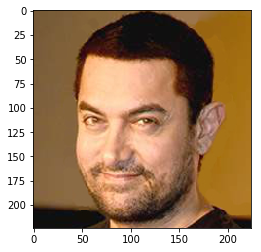

In [25]:
plt.imshow(np.asarray(im))


In [26]:
crpim = im

In [30]:
pred(facemodel, crpim, transform=False)
pred(facemodel, crpim, transform=True)


2 Aamir_Khan 0.994438 [9.476131e-09, 0.99443793]
2 Aamir_Khan 0.944438 [2.2034408e-06, 0.9444375]


In [28]:
import copy

In [34]:
description[102,0][0]


'Amy_Davidson'

In [35]:
description

array([[array(['A.J._Buckley'],
      dtype='<U12')],
       [array(['A.R._Rahman'],
      dtype='<U11')],
       [array(['Aamir_Khan'],
      dtype='<U10')],
       ..., 
       [array(['Zsa_Zsa_Gabor'],
      dtype='<U13')],
       [array(['Zulay_Henao'],
      dtype='<U11')],
       [array(['Zuleyka_Silver'],
      dtype='<U14')]], dtype=object)